#### Imports

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#### Get item name from products list
Function to get the name of the product from the product dataframe

In [2]:
def item(id):  
    return productsDF.loc[productsDF['product_id'] == id]['product_name'].tolist()[0]

#### Read dataframes
*user_reviews* dataframe is for working on the collaborative based filtering, all the features can be observed below. It has been sliced to get the only the top rated products for better clustering and regression. *productsDF* is the products dataframe which was used for content based filtering, it has been called here just to get the name of the products from the list.

In [3]:
user_reviews = pd.read_excel('user_reviews_sliced_multiple.xlsx')
productsDF = pd.read_excel("product_data.xlsx")
user_reviews

,user_id,product_id,username,stars,review,review_cleaned,combination_skin,dry_skin,normal_skin,oily_skin,sensitive_skin,skin_tone,skin_type,eye_color,hair_color
0,2803,110,Seymour2000,5,I feel like a lot of the people that are givin...,"['feel', 'like', 'lot', 'people', 'giving', 'l...",1,1,1,1,1,Porcelain,Combination,Brown,Brunette
1,6095,110,randurs,5,I recently started a job where I work in the s...,"['recently', 'started', 'job', 'work', 'sun', ...",1,1,1,1,1,Tan,Combination,Brown,Brunette
2,3001,110,Swerve2020,5,This was recommended to me while in the store ...,"['wa', 'recommended', 'store', 'dry', 'skin', ...",1,1,1,1,1,Fair,Dry,Green,Auburn
3,2492,110,PeachesNCream2,1,"I wanted to love this...really, I did! I norma...","['wanted', 'love', 'really', 'normally', 'love...",1,1,1,1,1,Fair,Dry,Blue,Auburn
4,2458,110,OshaJ,5,This is a great exfoliant. I was using Kate So...,"['great', 'exfoliant', 'wa', 'using', 'kate', ...",1,1,1,1,1,Tan,Combination,Green,Blonde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,3993,101,colorphile,4,"Even though I have dry skin, I prefer this one...","['even', 'though', 'dry', 'skin', 'prefer', 'o...",0,0,0,0,0,Tan,Combination,Brown,Black
2772,6486,101,stephaniesk,4,"While I don't dislike this toner, I don't love...","['dislike', 'toner', 'love', 'made', 'face', '...",0,0,0,0,0,Fair,Combination,Green,Blonde
2773,5806,101,nesse,2,"Being that I just turned 30, I've noticed my s...","['turned', 'noticed', 'skin', 'changing', 'wan...",0,0,0,0,0,Light,Oily,Hazel,Brunette
2774,3373,101,ajbeauty18,4,I absolutely love how this toner makes my skin...,"['absolutely', 'love', 'toner', 'make', 'skin'...",0,0,0,0,0,No data,No data,No data,No data


### K Nearest Neighbour
The difference between the previously implemented model and this new one is just the adjustment of the classification label. Previously product_id was being used to predict the suggested item, here we are classifying the ratings given by the user. Though the prediction is not being used for recommendation purposes, but this help with evaluation measure. Besides this the N neighbour algorithm is being used for recommending closest 5 item based on the ratings hence making it item-item based. <br>
The flow diagrams need not be adjusted since they were made generic to suit this situation. Although the text will be need to be rectified. Majorly the data preparation, implementation and the evaluation section. 

#### Prepare dateset for KNN
The main dataframe for user reviews has been sliced to maintain only the features requried for this implementation, mainly user_id, product_id and the ratings or the stars in this case. Duplicates have been droped while only the first occurence has been kept. *Duplicates* in this case represent values where user id and product id are the same, hence the subset. The *knn_dataframe* can be observed below with the features and their values. <br>
The warning in the red label can be ignored safely, it highlightes that there is a better way to remove duplicates than copy the specific values again to the original dataframe. 

In [4]:
knn_dataframe = user_reviews[['user_id', 'product_id', 'stars']]
knn_dataframe.drop_duplicates(subset=['user_id', 'product_id'], keep='first', inplace=True)
knn_dataframe

D:\My Projects\Skincare Recommendation\venv\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,user_id,product_id,stars
0,2803,110,5
1,6095,110,5
2,3001,110,5
3,2492,110,1
4,2458,110,5
...,...,...,...
2771,3993,101,4
2772,6486,101,4
2773,5806,101,2
2774,3373,101,4


#### Calculating ideal value for K
With 10 fold cross validation <br>
MAPE as the accuracy measure <br>
Train/Test split of 0.3 <br>
x = user_id <br>
y = product_id <br>
values = stars/ratings

Here we are identifying the best value for K neighbours to pass to the algorithm. The value comes out to be 5 with a MAPE value of -0.45 meaning the model is 55% accurate. The hit ratio and precision/recall can be observed next.

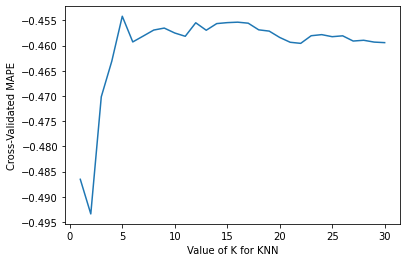

In [5]:
array = knn_dataframe.values
X = array[:,0:2]
y = array[:,2]
k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='neg_mean_absolute_percentage_error')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MAPE')
plt.show()

#### Training and testing with Accuracy, precision and recall
Training and testing the model with above describes hyperparameters.

In [6]:
X_train, X_test, Y_train, Y_test= train_test_split(X, y, test_size=0.3,random_state=7)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
# pickle.dump(knn, open('knn.sav', 'wb'))
# joblib.dump(knn, 'knn.sav')
predictions = knn.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.5714285714285714
[[  2   2   1   2  28]
 [  2   0   1   5  23]
 [  2   1   3   3  30]
 [  3   0   2  10  68]
 [ 10   4  15  35 301]]
              precision    recall  f1-score   support

           1       0.11      0.06      0.07        35
           2       0.00      0.00      0.00        31
           3       0.14      0.08      0.10        39
           4       0.18      0.12      0.14        83
           5       0.67      0.82      0.74       365

    accuracy                           0.57       553
   macro avg       0.22      0.22      0.21       553
weighted avg       0.49      0.57      0.52       553



#### Classifying rating for the entered product
User input provided is the product id and the user id which will then classify the product rating. Again, it is to be highlighted that this model is not being used for predicition purpose. This is just to test the implementation and approach. Multiple approaches can found using this approach. You may visit [Towards Data Science | Susan Li | Recommender System](https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c) or any other for reference. 

In [7]:
new_val = [[110, 2]]
print(new_val)
predictions = knn.predict(new_val)
print(predictions.tolist())

[[110, 2]]
[5]


#### Sparse matrix for memory preservation
This is the approach which is being used for suggesting similar products. Here were prepare the knn dataframe for the above prepare N neighbor model. The dataframe is converted in to a regular matrix by using pivot and then into a *sparse matrix* using csr_matrix to save on system resource and to get rid of 0 values that play no vital role in the algorithm whilst also making the model faster.

In [8]:
knn_pivot = knn_dataframe.pivot_table(index='product_id', columns='user_id', values='stars').fillna(0)
knn_matrix = csr_matrix(knn_pivot.values)
knn_matrix

<316x1210 sparse matrix of type '<class 'numpy.float64'>'
	with 1841 stored elements in Compressed Sparse Row format>

#### Fitting the KNN model
The approach being taken here is the brutre algorithm being used for calculating the distance vector and the cosine similarity index to measure the similarity between multiple products closest to the cluster.

In [9]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(knn_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

#### Predicting N nearest neighbours
Now the entered user product is taken as the input and the 5 nearest neighbours are displayed based on their cosine similarity. N_neighbour is 6 meaning one for the product itself and 5 others. Unlike the Tf-IDF vectorizer the cosine index here does not measure the similarity ration based on the contents name, ingredients and brand, but here the actual distance between the plotted points is being calculated, meaning the larger the value the further the product ID is from the user entered value.

In [10]:
query_index = 167
distances,indices=model_knn.kneighbors(knn_pivot.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)
print("Distances -->",distances," Indices -->",indices)
 
# print(distances.flatten())
# print(len(distances.flatten()))
 
for i in range(0,len(distances.flatten())):
    if i==0:
        print("Recommendation for {0}: {1}\n".format(query_index, item(query_index)))
    else:
        print("{0}. {1}: {3}, with distance of {2}:".format(i,indices.flatten()[i],distances.flatten()[i], item(indices.flatten()[i])))

Distances --> [[0.         0.86090704 0.88752179 0.89437782 0.89701552 0.91591748]]  Indices --> [[167 130  56 197  57  10]]
Recommendation for 167: Max Complexion Correction Pads

1. 130: Fresh Pressed Renewing Powder Cleanser with Pure Vitamin C, with distance of 0.8609070442733859:
2. 56: Charlotte's Magic Cream Mini, with distance of 0.8875217946598074:
3. 197: Pore-Balanceâ„¢ Facial Sauna Scrub, with distance of 0.8943778187027792:
4. 57: Checks and Balancesâ„¢ Frothy Face Wash, with distance of 0.8970155181802966:
5. 10: Acne Healing Dots, with distance of 0.9159174798094053:


### Singular Value Decomposition
SVD uses matrix factorization for recommending products that have some correlation based on the user ratings. 

#### Data load and Train/Test split
Train test split from the Surprise library. The dataframes is the same from the above implementation meaning the identical features have been utilized here with a train test split of 30%

In [11]:
reader = Reader(line_format='item user rating', sep=',')
data = Dataset.load_from_df(knn_dataframe, reader=reader)
trainset, testset = tts(data, test_size=.3)

#### Fitting
The model is fitted

In [12]:
svd = SVD()
svd.fit(trainset)

#### Testing and Accuracy
Average demand is 4.23 meaning the RMSE and MAE are relatively low and the accruacy is around 81.8% I say around because the value can vary each time the model is executed since train test data is altered by the predetermined *tts* import of the surprise library. <br>
Since 5 is the max value hence 0.91/5 * 100 = 18.2 and 100-18.2=81.8

The accuracy measures used here MAE and RMSE. These both are negatively confined measures meaning the lower the value the better. They can range from 0 to inf. To determine the evaluation measure it is best to identify the averge demand for the classification label which can help identify whether the values being received from the evaluation measures is justifiable or not.

In [13]:
predictions = svd.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.2318
MAE:  0.9807


0.9806635240128121

#### Average demand

In [14]:
knn_dataframe.stars.mean()

4.236284627919609

#### Matrix factorization
The model trained and tested above is being prepare here to adjust the API needs i.e. to take the product ID and user ID as the input and fit a regression line as close as possible to the ratings provided and return with the best suited values for the entered ID. 316 represents the product ID and 1210 is the user that has rated the item.

In [15]:
svd = TruncatedSVD(n_components=12, random_state=17)
matrix = svd.fit_transform(knn_pivot)
print(knn_pivot.shape)
matrix.shape

(316, 1210)


(316, 12)

#### Correlation Matrix
Correlation matrix is prepared.

In [16]:
corr = np.corrcoef(matrix)
corr.shape

(316, 316)

#### Getting the index for the entered product ID
Since we have a 2D matirx here, the index is not the actual product ID, but the index for the matrix row itself. Hence, we extract the matrix index to get the row for the user entered product ID and then use that *current_corr* value for prediction or recommendation purposes in the next cell.

In [17]:
product_id = 167
product_id_index = knn_pivot.index
product_id_index_list = list(product_id_index)
current_corr = product_id_index_list.index(product_id)
current_corr

110

#### Prediction
Recommend the items closest to the entered product ID based on the regression model.

In [18]:
current_corr_hand = corr[current_corr]
print("Recommendation for {}: {}".format(product_id, item(product_id)))
for x in list(product_id_index[(current_corr_hand < 1.0) & (current_corr_hand > 0.9)]):
    print("{}: {}".format(x, item(x)))

Recommendation for 167: Max Complexion Correction Pads
23: Anti Bac Clearing Lotion
102: Essential Power Skin Toner for Combination to Oily Skin
